<ipython-input-16-c7721f9f58fe>:129: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 1, 1)
<ipython-input-16-c7721f9f58fe>:136: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2, 1, 2)
<ipython-input-16-c7721f9f58fe>:129: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created

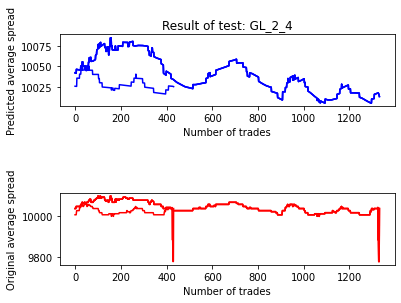

In [16]:
import os
import csv
import string
import random
import numpy as np
import pandas as pd
from scipy import optimize as optim
from scipy.stats import norm
from scipy.stats import mode
from scipy.stats import bartlett
from scipy.stats import sem
from scipy.stats import ttest_ind
from statistics import NormalDist
import matplotlib.pyplot as plt

    

def calculatebid_inelastic(prev_bid, mean, std, alpha, eps):
    
    pred_bid = 0
        
    if prev_bid == mean:
        pi = 0.5
        ped_bid = (alpha*prev_bid - alpha*pi*prev_bid + 0.5*mean - 0.5*alpha*mean) / (alpha - alpha*pi - 0.5*alpha + 0.5)
            
    else:
        pi = 1-(norm.cdf(prev_bid-eps, mean, std) + norm.sf(prev_bid + eps, mean, std))
        ped_bid = (alpha*prev_bid - alpha*pi*prev_bid + 0.5*mean - 0.5*alpha*mean) / (alpha - alpha*pi - 0.5*alpha + 0.5)
    
    return prev_bid



def calculateask_inelastic(prev_ask, mean, std, alpha, eps):
    
    pred_ask = 0
    
    if prev_ask == mean:
        pi = 0.5
        pred_ask = (0.5*alpha*mean - 0.5*mean - alpha*pi*prev_ask)/(-alpha*pi -0.5 + 0.5*alpha)
    
    else:
        pi = 1-(norm.cdf(prev_ask-eps, mean, std) + norm.sf(prev_ask+eps, mean, std))
        pred_ask = (0.5*alpha*mean - 0.5*mean - alpha*pi*prev_ask)/(-alpha*pi -0.5 + 0.5*alpha)
    
    return pred_ask



def predict(ms_spread, alpha, sample, margin):
    #creating an array structure alike ms_spread
    predicted_spread = np.zeros((ms_type.size - sample, 3))


    for x in range(0, predicted_spread[:, 0].size):
        mu, std = norm.fit(ms_spread[x:x+sample-1,2])
    
        predicted_spread[x, 0] = calculatebid_inelastic(prev_bid = ms_spread[x+sample-1 , 0], mean = mu, std = std, alpha = alpha, eps = margin)
        predicted_spread[x, 1] = calculateask_inelastic(prev_ask = ms_spread[x+sample-1 , 1], mean = mu, std = std, alpha = alpha, eps = margin)
        predicted_spread[x, 2] = np.mean([predicted_spread[x, 0], predicted_spread[x, 1]])
        
        if np.isfinite(predicted_spread[x, 0]) == False or np.isfinite(predicted_spread[x, 1]) == False or np.isfinite(predicted_spread[x, 2]) == False:
            predicted_spread[x, 0] = mu
            predicted_spread[x, 1] = mu
            predicted_spread[x, 2] = mu
        
    return predicted_spread
    


def littletrader(preds, s):
    inv = 1
    tres = 100
    sample = s[:,2].size-preds[:,2].size
    #when the trader buys, it takes place on the market maker's ask price, and his inventory grows, though his treasury decreases
    #when the trades sells, it takes place on the market maker's bid price, and his inventory decreases, though his treasury increases
    
    lask =0 
    lbid = 0
    for x in range(0, preds[:,0].size):
    
        if x == 0:
            lbid = s[x, 0]
            lask = s[x, 1]
            inv = inv -1
            tres = tres + lbid
        elif lask > preds[x, 1] and inv == 0:
            lask = s[x, 1]
            inv = inv + 1
            tres = tres - lask
        elif lbid < preds[x, 0] and inv == 1:
            lbid = s[x,0]
            inv = inv - 1
            tres = tres + lbid
    
    if inv == 0:
        return tres
    elif inv == 1:
        return (tres + inv*s[-1,2])
    else: 
        return -1000

    

def results(preds, s, filepath, testname):
    res = np.zeros(11)
    diff = s[:,0].size - preds[:,0].size
    
    #calculating standard expected value and deviation from original spread
    res[0], res[1] = norm.fit(s[diff:,2])
    
    #calculating standard expected value and deviation from predicted spread
    res[2], res[3] = norm.fit(preds[:,2])
    
    #calculating the most common value of the original spread
    res[4], trash = mode(s[diff:,2])
    #calculating the most common value of the predicted spread
    res[5], trash = mode(preds[:,2])
    
    #calculating standard error of original spread
    res[6] = sem(s[diff:,2])
    #calculating standard error of predicted spread
    res[7] = sem(preds[:,2])
    
    #bartlett test p value
    trash, res[8] = bartlett(s[diff:,2], preds[:,2]) 
    
    # student test t value
    trash, res[9] = ttest_ind(s[diff:,2], preds[:,2])
    
    #littletrader
    res[10] = littletrader(preds = preds, s = s)

    #ploting the original spread and the expected spread, then saving them
    plt.subplot(2, 1, 1)
    plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=1.2)
    plt.title('Result of test: ' + testname)
    plt.plot(pred_spread[:,2], 'b-')
    plt.xlabel('Number of trades')
    plt.ylabel('Predicted average spread')

    plt.subplot(2, 1, 2)
    plt.plot(ms_spread[diff:, 2], 'r-')
    plt.xlabel('Number of trades')
    plt.ylabel('Original average spread')
    plt.savefig(testname, dpi=1000)
    
    #saving predicted values into xlsx
    toexcel = pd.DataFrame(data = {'PRED_BID': preds[:,0], 'PRED_ASK' : preds[:,1], 'PRED_MEAN' : preds[:,2]} )
    toexcel.to_excel(filepath, sheet_name = testname)
    
    return res

    
#opening data from excel
ticker = 'otp'
ms_df = pd.read_excel("data.xlsx", sheet_name = ticker) 

#converting data to numpy arrays
ms_df = ms_df.to_numpy() 

#dividing data to multiple arrays
ms_size = ms_df[: , 1]
ms_time = ms_df[:, 2]
ms_type = ms_df[:,3]
ms_values= ms_df[:,4]


#creating an array, where first column Bid, second column Ask, third column mean; and where the unknown Ask or Bid price is same as the previous
ms_spread = np.zeros((ms_values.size, 3)) 
for x in range(0, ms_values.size):
    if x == 0 and ticker == 'ms':
        ms_spread[0, 1] = ms_values[0]
        ms_spread[0, 0] = ms_values[1]
        ms_spread[0, 2] = (ms_spread[0, 0] + ms_spread[0, 1])/2
    elif x==0 and ticker =='otp':
        ms_spread[0, 0] = ms_values[0]
        ms_spread[0, 1] = ms_values[1]
        ms_spread[0, 2] = (ms_spread[0, 0] + ms_spread[0, 1])/2
    else:
        if ms_type[x] == "BEST_ASK":
            ms_spread[x, 1]= ms_values[x]
            ms_spread[x, 0]= ms_spread[x-1, 0]
            ms_spread[x, 2]= (ms_spread[x, 0] + ms_spread[x, 1])/2
        elif ms_type[x] == "BEST_BID":
            ms_spread[x, 1]= ms_spread[x-1, 1]
            ms_spread[x, 0]= ms_values[x]
            ms_spread[x, 2]= (ms_spread[x, 0] + ms_spread[x, 1])/2

indicators = np.zeros((11,8))
pred_spread = predict(ms_spread, alpha = 0.1, sample = 100, margin = 0.001)
indicators[:, 0] = results(pred_spread, ms_spread, filepath = 'Glosten_Milgrom_test_results.xlsx', testname = 'GL_1_1')
pred_spread = predict(ms_spread, alpha = 0.2, sample = 100, margin = 0.001)
indicators[:, 1] = results(pred_spread, ms_spread, filepath = 'Glosten_Milgrom_test_results.xlsx', testname = 'GL_1_2')
pred_spread = predict(ms_spread, alpha = 0.1, sample = 1000, margin = 0.001)
indicators[:, 2] = results(pred_spread, ms_spread, filepath = 'Glosten_Milgrom_test_results.xlsx', testname = 'GL_1_3')
pred_spread = predict(ms_spread, alpha = 0.1, sample = 100, margin = 0.01)
indicators[:, 3] = results(pred_spread, ms_spread, filepath = 'Glosten_Milgrom_test_results.xlsx', testname = 'GL_1_4')

pred_spread = predict(ms_spread, alpha = 0.1, sample = 100, margin = 0.001)
indicators[:, 4] = results(pred_spread, ms_spread, filepath = 'Glosten_Milgrom_test_results.xlsx', testname = 'GL_2_1')
pred_spread = predict(ms_spread, alpha = 0.2, sample = 100, margin = 0.001)
indicators[:, 5] = results(pred_spread, ms_spread, filepath = 'Glosten_Milgrom_test_results.xlsx', testname = 'GL_2_2')
pred_spread = predict(ms_spread, alpha = 0.1, sample = 1000, margin = 0.001)
indicators[:, 6] = results(pred_spread, ms_spread, filepath = 'Glosten_Milgrom_test_results.xlsx', testname = 'GL_2_3')
pred_spread = predict(ms_spread, alpha = 0.1, sample = 100, margin = 0.01)
indicators[:, 7] = results(pred_spread, ms_spread, filepath = 'Glosten_Milgrom_test_results.xlsx', testname = 'GL_2_4')



In [17]:
toout = pd.DataFrame(data = {'Original mean value': indicators[0,:], 'Original standard deviation' : indicators[1,:], 'Predicted mean value' : indicators[2,:], 'Predicted standard deviation' : indicators[3,:], 'Mode value of original' : indicators[4,:], 'Mode value of predicted' : indicators[5,:], 'Standard error of mean original' : indicators[6,:], 'Standard error of mean predicted' : indicators[7,:], 'Bartlett test p value' : indicators[8,:], 'Student test p value' : indicators[9,:], 'Little trader value' : indicators[10,:]} )

toout.to_excel('GL_indicators.xlsx')